# Monte Carlo Simulation for BHP
Forecast BHP price based on historical averages and volatility


## Methodology
- Use historical data for forecast of future price
- Estimating 1 year forecast by using 1 years of historical data - daily close price.
- Calculate mean and standard deviation of daily returns (%) for historical dataset
- Perform Monte Carlo simulation using log-normal distribution
- Simulate possible prices at trading day *n* into the future
- Simulate at least 1000 possible prices at day *n*
- Forecast will be the average price of all simulated prices

In [22]:
import random
import numpy as np
import pandas as pd
import pandas.io.data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style("dark")
sns.set_context("talk")

#### Approximate trading days in a year

In [23]:
DAYSINYEAR = 365
WEEKSINYEAR = 52
AUSPUBLICHOLIDAYS = 8
yearTradingDays = DAYSINYEAR - (WEEKSINYEAR*2) - AUSPUBLICHOLIDAYS
print("Approx. Trading Days In Year:", yearTradingDays)

Approx. Trading Days In Year: 253


#### Import historical BHP Prices
 - Import data from Yahoo
 - If forecasting for *n* days, import *n* days of historical data
 - Plot daily close prices
 - Get summary statistics

In [24]:
n = yearTradingDays

In [25]:
# Date range for historical data
start = datetime.date.today() - datetime.timedelta(days=n)
end = datetime.date.today() 

In [26]:
dataBHP = web.DataReader("BHP.AX", 'yahoo', start,end)

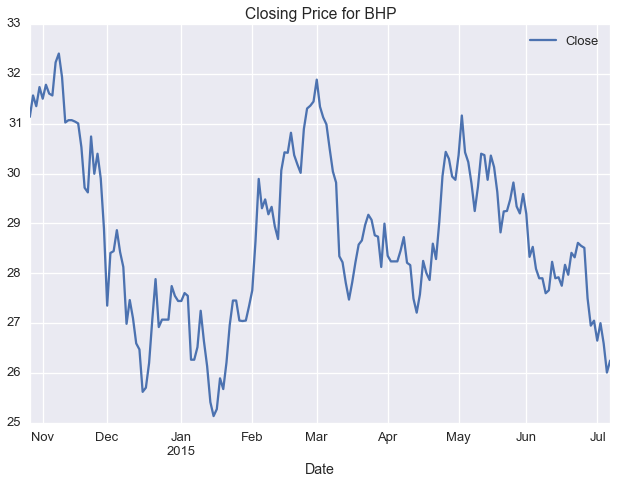

In [27]:
dataBHP.Close.plot(legend=True,title="Closing Price for BHP")

#### Closing price statistics

In [28]:
dataBHP.Close.describe()

count    181.000000
mean      28.748725
std        1.654822
min       25.136500
25%       27.500000
50%       28.550000
75%       30.014300
max       32.406400
Name: Close, dtype: float64

#### Let's analyse daily % returns for the dataset.
- Plot daily % returns
- Get summary statistics

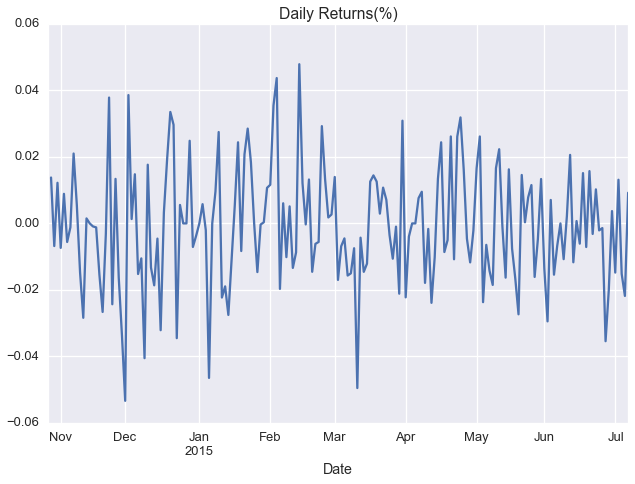

In [29]:
dataBHP.Close.pct_change().plot(title="Daily Returns(%)")

#### Percentage Return Statistics

In [30]:
dataBHP.Close.pct_change().describe()

count    180.000000
mean      -0.000789
std        0.017878
min       -0.053363
25%       -0.013297
50%       -0.001078
75%        0.012146
max        0.047885
Name: Close, dtype: float64

#### Remember the latest price for BHP. We will use this as a starting point to forecast prices

In [31]:
dataBHPlastPrice = dataBHP.Close.iloc[-1]
print(dataBHPlastPrice)

26.25


#### Some helper functions for the Monte Carlo Simulation
- Stock prices generally have a log-normal distribution
- *simulate* will generate a single possible % return based on mean, standard deviation

In [32]:
def lognormal(mu, std_dev):
    """Apply the log-normal distribution."""
    return random.lognormvariate(mu, std_dev)

def simulate(days, start_price,mu, std_dev, distribution):
    """Simulate the asset for the specified number of days."""
    price = start_price
    for day in range(days):
        price = max(0, price * distribution(mu, std_dev))
    return price

#### Keep a running table of means and standard deviations of BHP Daily Percentage Returns
- If we are forecasting for day *n* into the future, calculate the mean and standard deviation of the previous *n* days
- Use this mean and standard deviation to generate *s* possible prices for day *n*

In [33]:
muList = pd.Series([dataBHP.Close.pct_change().iloc[-i-1:].mean() for i in range(n)],name='mu')

In [34]:
stdList =[dataBHP.Close.pct_change().iloc[-i-1:].std() for i in range(n)]
stdList[0] = 0.0
stdList = pd.Series(stdList,name='stdev')

#### Generate *s* possible prices for each trading day

In [35]:
s = 1000

#### Intialize a table which will contain all the forecasted prices

In [36]:
runningStats = pd.concat([muList,stdList], axis=1)

In [37]:
np.full([n,s], None)

forecasts = pd.DataFrame(data=np.empty([n,s]), columns=[col for col in range(s)],
                       index=[row for row in range(n)])

#### Run the Monte Carlo Simulation to populate the forecast table

In [38]:
%%time
for d in range(n):
    for trial in range(s):
        forecasts.iloc[d,trial]=simulate(days=d, 
                                         start_price=dataBHPlastPrice, 
                                         mu=runningStats.mu.iloc[d],
                                         std_dev=runningStats.stdev.iloc[d], 
                                         distribution=lognormal)

Wall time: 2min 24s


#### Plot the forecast table
- Each day has 1000 generated price samples
- A lot of uncertainty as we get further away from today's price

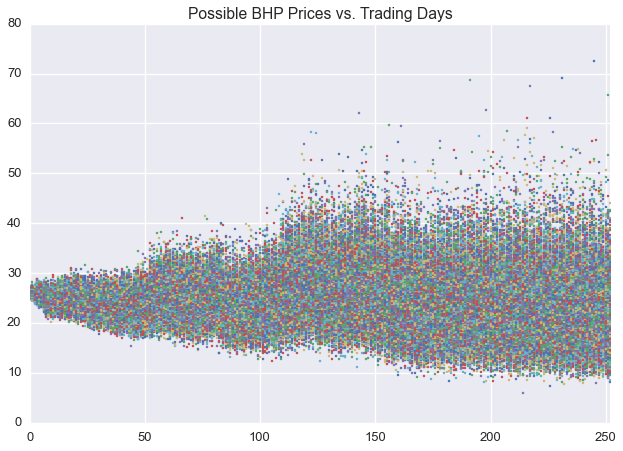

In [106]:
forecasts.plot(style='.', legend=False, linewidth=0.5,title="Possible BHP Prices vs. Trading Days", ms=5)

#### Let's look at the distribution of possible prices at a point in time
- Example: n=100 (100 trading days away)
- Take a slice at n=100 from the graph above
- Visualise distribution of that slice of samples

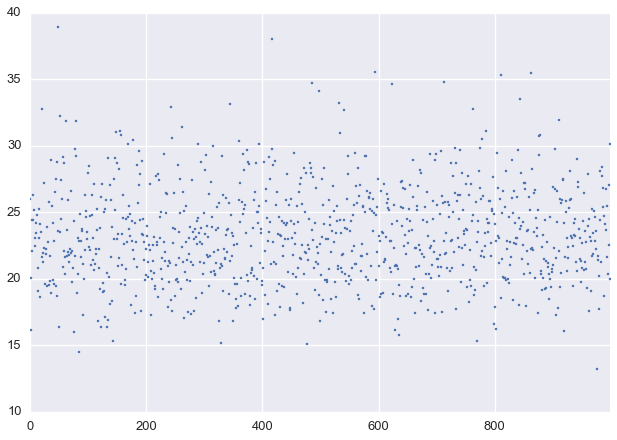

In [111]:
forecasts.iloc[100].plot(style=".", ms=5.0)

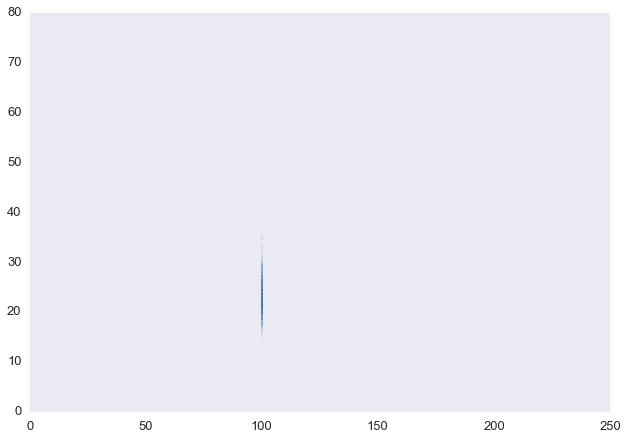

In [92]:
a = forecasts.iloc[100]
b = [100 for i in range(s)]
plt.xlim(0,250)
plt.ylim(0,80)
plt.plot(b,a, "o",ms=0.5)

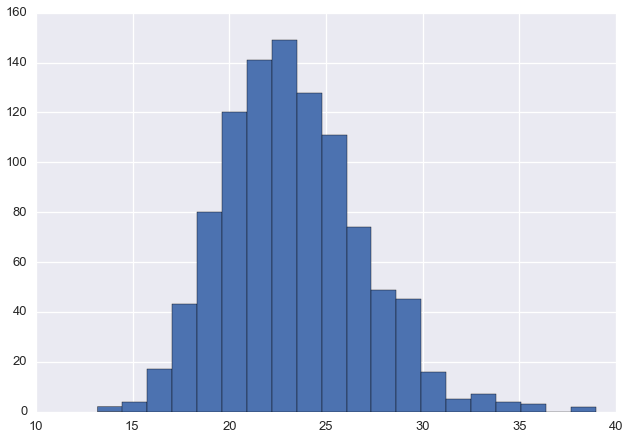

In [93]:
forecasts.iloc[100].hist(bins=20)

In [41]:
forecasts.iloc[100].describe()

count    1000.000000
mean       23.292004
std         3.612774
min        13.186177
25%        20.797621
50%        23.016878
75%        25.526605
max        38.932201
Name: 100, dtype: float64

#### Let's look at the stats for n=200 (200 trading days away)
- Standard Deviation is signficantly higher at n=200 than at n=100 - indicating greater uncertainty of what the price will be further away in time

In [42]:
forecasts.iloc[200].describe()

count    1000.000000
mean       23.164720
std         6.130896
min         9.432972
25%        18.777211
50%        22.403868
75%        26.676979
max        53.255505
Name: 200, dtype: float64

#### Let's forecast BHP price 4 weeks from now
- Look at the distribution of possible prices at n=4*5=20
- Use the mean as our forecast

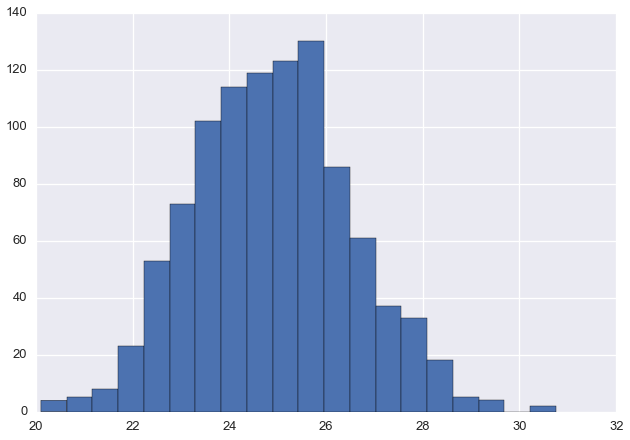

In [43]:
forecasts.iloc[20].hist(bins=20)

In [44]:
forecasts.iloc[20].mean()

24.909282578061823

#### Forecast the price action across *n* days
- Plot the mean of all possible prices for each day

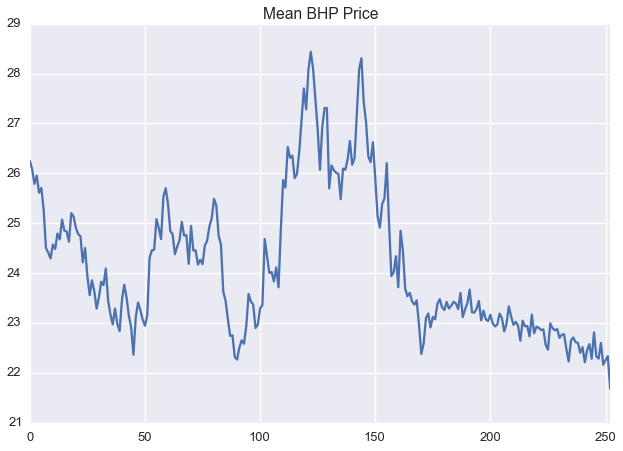

In [45]:
forecasts.mean(axis=1).plot(title="Mean BHP Price")